In [10]:
#!pip install tflearn

  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127300 sha256=9c34333ef820fba8bd6ad65c9f890ede1659e45602b8982f19bf6868e7dac78e
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\65\9b\15\cb1e6b279c14ed897530d15cfd7da8e3df8a947e593f5cfe59
Successfully built tflearn


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve,recall_score,precision_score,f1_score,auc,confusion_matrix

import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping
import tflearn.datasets.oxflower17 as oxflower17

In [2]:
seed = 123
np.random.seed(seed)

# Import the data. Analyse the dimensions of the data

In [3]:
x, y = oxflower17.load_data(one_hot=True)

In [4]:
print("Image shape" ,x.shape)
print("Target class shape" ,y.shape)

Image shape (1360, 224, 224, 3)
Target class shape (1360, 17)


# Data visualisation

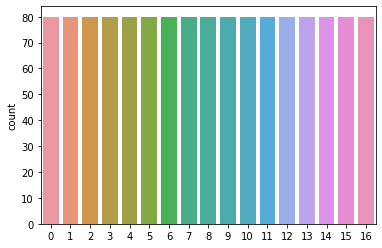

In [5]:
sns.countplot(x=y.argmax(axis=1))

Observation - Samples for all the class (0 -17) are distributed uniform  

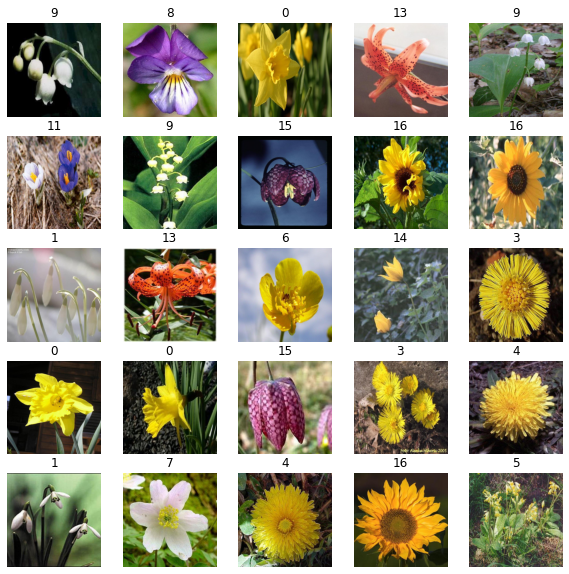

In [8]:
labels = y.argmax(axis=1)

fig=plt.figure(figsize=(10,10))
columns=5
rows=5
for i in range(1, columns*rows+1):
    img=x[i]
    fig.add_subplot(rows,columns,i)
    plt.imshow(img)
    plt.title(labels[i])
    plt.axis('off')
plt.show()

# applying filters for the image

Kernal Size -  5


<Figure size 720x720 with 0 Axes>

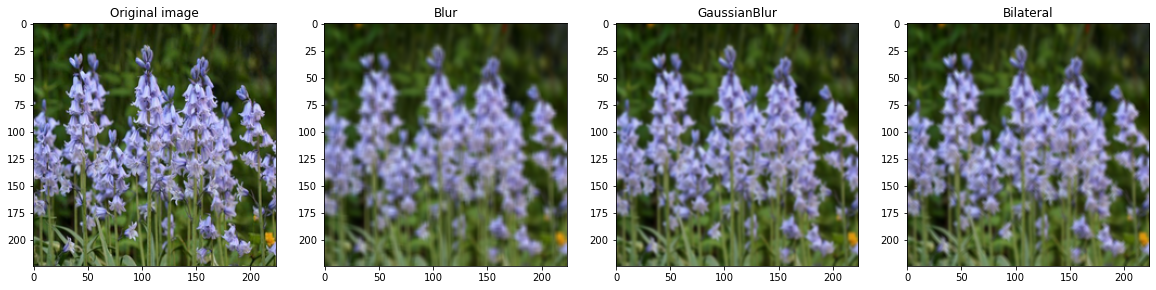

Kernal Size -  7


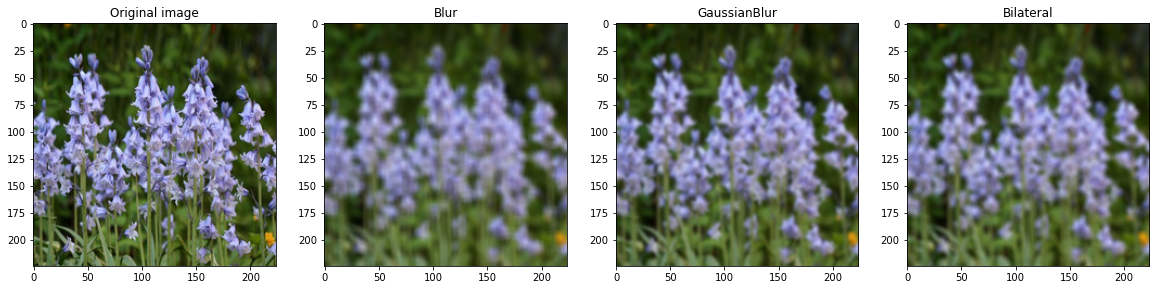

Kernal Size -  11


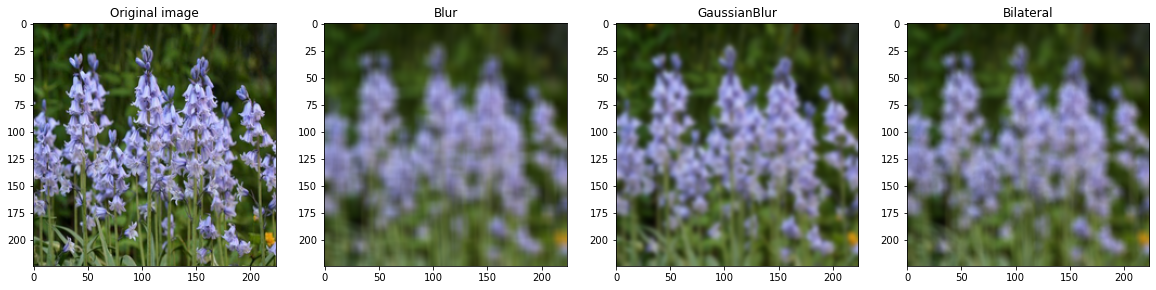

Kernal Size -  5


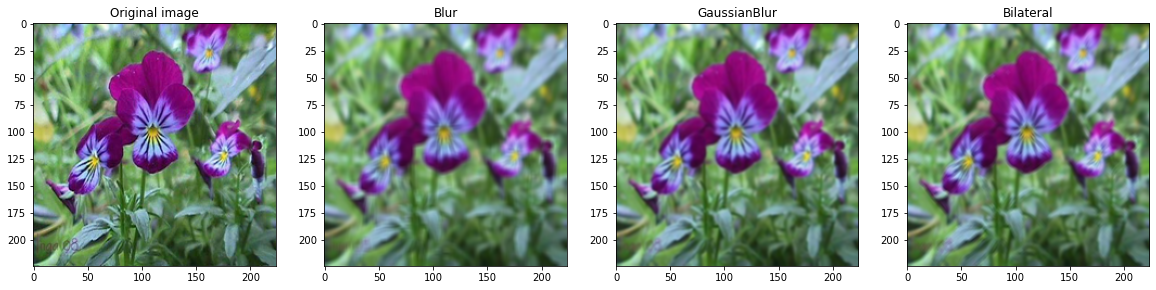

Kernal Size -  7


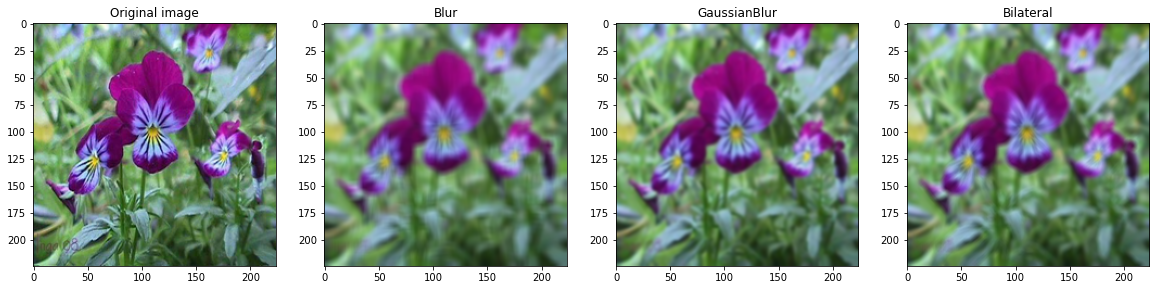

Kernal Size -  11


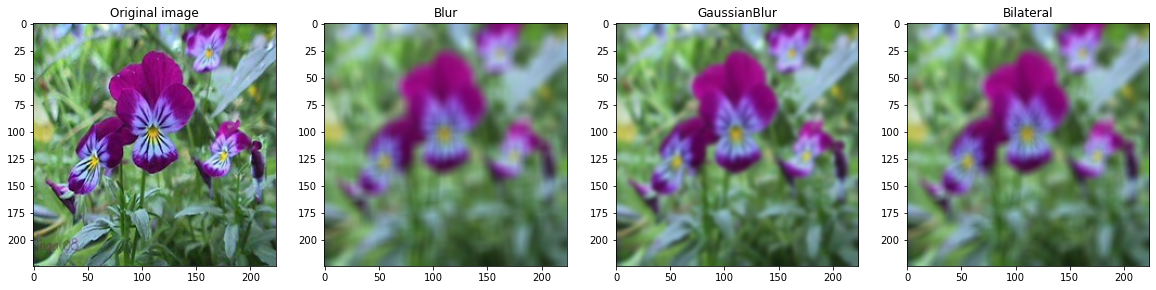

In [28]:
kernal_size_list = [5,7,11]
fig=plt.figure(figsize=(10,10))
columns=5
rows=5


def plot_img(images,title):
  fig, axs = plt.subplots(nrows = 1, ncols = len(images),
                          figsize = (20, 20))
  index = 0
  for img in images:
        axs[index].imshow(img)
        axs[index].set_title(title[index])
        index = index +1
       
  plt.show()



for index in range(2):
    image_index = np.random.randint(0,1360)
    for kernal in kernal_size_list:
            print( "Kernal Size - ",kernal)
            img=x[image_index]
            a_img = cv2.blur(img,(kernal,kernal))
            g_img = cv2.GaussianBlur(img,(kernal,kernal),0)
            b_img = cv2.bilateralFilter(img,kernal,75,75)

            plot_img([img,a_img,g_img,b_img],["Original image","Blur","GaussianBlur","Bilateral"])



# Training Model

In [29]:
# data split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)

## Normalize 
X_train = X_train /  255
X_test = X_test /  255

print("X_train min / max ", X_train.min(),X_train.max())
print("X_test min / max ", X_test.min(),X_test.max())

X_train_svc = X_train.reshape(X_train.shape[0],3*img_width*img_height)
print("X_train_svc data shape ", X_train_svc.shape)

X_test_svc= X_test.reshape(X_test.shape[0],3*img_width*img_height)
print("X_train_svc data shape ", X_test_svc.shape)

y_train_svc = y_train.argmax(axis=1)
print("y_train_svc data shape ", y_train_svc.shape)

y_test_svc = y_test.argmax(axis=1)
print("y_test_svc data shape ", y_test_svc.shape)


print("X_train data shape ", X_train.shape)
print("y_train data shape ", y_train.shape)

print("X_test data shape ", X_test.shape)
print("y_test data shape ", y_test.shape)



NameError: name 'train_test_split' is not defined